In [792]:
import os
import sys
from tqdm import tqdm

import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
from scipy import signal

from scipy import optimize
from torch.fft import fft, ifft

from scipy.stats import kurtosis, skew
from timm.models.layers.conv2d_same import conv2d_same

In [817]:
class CNNModule(nn.Module):
    def __init__(self, sequence_shape, kernel_size=10, base_channel=64, module_count=2, pooling_coef=2,
                 cnn_padding='same', padding_mode = 'zeros', channel_multiplier=2, act_fn='relu'):
        assert pooling_coef*base_channel == int(pooling_coef*base_channel)
        act_func_dict = {
                            'relu':nn.ReLU(inplace = True), 
                            'selu':nn.SELU(inplace = True),
                            'elu':nn.ELU(inplace = True),
                        }
        super().__init__()
        self.sequence_shape = sequence_shape # (channel, length) tuple
        self.kernel_size = kernel_size
        self.base_channel = base_channel
        self.module_count = module_count
        self.pooling_coef = pooling_coef
        self.padding_mode = padding_mode
        self.cnn_padding = cnn_padding
        self.channel_multiplier = channel_multiplier
        self.act_fn = act_func_dict[act_fn]
        
        self.model = self.build()
        
        
    def build(self):
        channel = self.base_channel
        length = self.sequence_shape[1]
        model = [nn.Conv1d(in_channels = self.sequence_shape[0], out_channels = channel, kernel_size = self.kernel_size,
                          padding = self.cnn_padding, padding_mode = self.padding_mode),
                self.act_fn]
        
        priv_channel = channel
        channel *= self.channel_multiplier
        
        for _ in range(self.module_count):
            model += [
                nn.Conv1d(in_channels=priv_channel, out_channels=channel, kernel_size=self.kernel_size, 
                            padding='same', padding_mode=self.padding_mode),
                self.act_fn,
                nn.Conv1d(in_channels=channel, out_channels=channel, kernel_size=self.kernel_size, 
                            padding='same', padding_mode=self.padding_mode),
                self.act_fn,
                nn.BatchNorm1d(channel),
                nn.MaxPool1d(2, stride=2)
            ]
        
            length = int(length/2)
            priv_channel = channel
            channel *= self.channel_multiplier
            
        return nn.Sequential(*model)
        

    def forward(self, x):
        return self.model(x)
    
    
    
class StatAnalModule(nn.Module):
    def __init__(self, length, complexity = 2):
        super().__init__()
        self.length = length
        self.complexity = complexity
        
    def moment(self, x, order):
        return (((x - torch.mean(x, -1).reshape(-1,1))**order).sum(-1))
    
    def forward(self, x):
        rms = torch.sqrt(torch.mean(torch.pow(x, 2), -1))
        maxima = torch.max(x, -1)[0]
        minima = torch.min(x, -1)[0]
        result = torch.cat([torch.mean(x, -1), maxima, minima, rms, torch.var(x, -1)])
        if self.complexity > 0:
            skew = self.moment(x, 3)/(torch.std(x, -1))**3*self.length/(self.length-1)/(self.length-2)
            kurto = self.length/(self.length-1)**2 * self.moment(x, 4) / (torch.std(x,-1))**4 -3
            result = torch.cat([result, skew, kurto])

        elif self.complexity > 1:
            
            crest_factor = torch.abs(x).max(-1)[0]/rms
            meanabs = torch.abs(x).mean(-1)
            impulse_factor = (maxima-minima) / meanabs
            shape_factor = rms / meanabs
            result = torch.cat([result, crest_factor, impulse_factor, shape_factor])
        
        return result
    

class CWT(nn.Module):
    def __init__(self, length, in_channel=1, out_channel=4):
        super().__init__()
        self.T = length # 시퀀스 길이
        self.out_channel = out_channel # not supported yet
        self.t_list = [int(self.T/self.out_channel) * i for i in range(1,out_channel+1)] 
        self.in_channel = in_channel
        
    def morlet(self, T, f0 = 6):
        t = torch.linspace(-2*torch.pi, 2*torch.pi, T)
        filt = torch.pi**(1/4)* torch.exp(1j*6*t - (t**2)/2).reshape(1,1,1,-1).real
        return torch.cat([filt for _ in range(self.in_channel)], axis = -2)
    
    def forward(self, x):
        return torch.cat([F.conv2d(x.float(), self.morlet(T).float(), padding = 'same') for T in self.t_list]).reshape(self.out_channel, -1)

In [840]:
data = torch.rand(2, 128)
cnn = CNNModule((2,128))
cnn

CNNModule(
  (act_fn): ReLU(inplace=True)
  (model): Sequential(
    (0): Conv1d(2, 64, kernel_size=(10,), stride=(1,), padding=same)
    (1): ReLU(inplace=True)
    (2): Conv1d(64, 128, kernel_size=(10,), stride=(1,), padding=same)
    (3): ReLU(inplace=True)
    (4): Conv1d(128, 128, kernel_size=(10,), stride=(1,), padding=same)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv1d(128, 256, kernel_size=(10,), stride=(1,), padding=same)
    (9): ReLU(inplace=True)
    (10): Conv1d(256, 256, kernel_size=(10,), stride=(1,), padding=same)
    (11): ReLU(inplace=True)
    (12): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
)

In [841]:
cnn(data.reshape(1, 2, 128)).shape

torch.Size([1, 256, 32])

In [839]:
stat = StatAnalModule(128)
stat(data)

tensor([ 0.4967,  0.5319,  0.9710,  0.9969,  0.0055,  0.0284,  0.5730,  0.6021,
         0.0823,  0.0803, -0.0130, -0.1208, -1.2584, -1.2489])

torch.Size([1, 1, 1, 3000])
(1500, 3000)


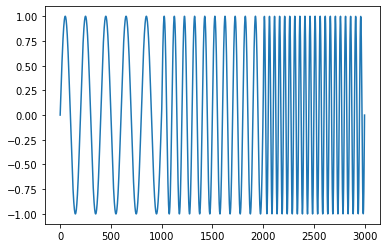

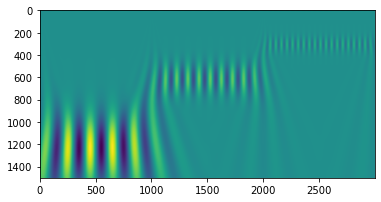

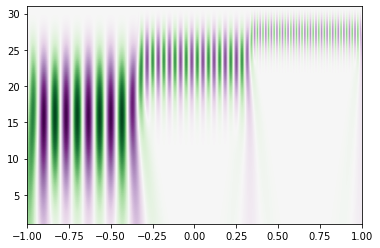

In [818]:
step = 1000
x = torch.linspace(0, 10, step)
sin = torch.sin(x)
lst = np.zeros((1,3*step))
test = torch.cat([torch.sin(torch.pi*x), torch.sin(torch.pi*2*x), torch.sin(torch.pi*4*x)]).reshape(1,1,1,-1)
print(test.shape)
a = CWT(length = 3000, out_channel = 1500)
lst = a(test).numpy()
print(lst.shape)
plt.plot(test.numpy().reshape(-1,1))
plt.show()

plt.imshow(lst)
plt.show()

widths = np.arange(1, 100)
cwtmatr = signal.cwt(test.numpy().reshape(-1), signal.ricker, widths)

plt.imshow(
    cwtmatr,
    extent=[-1, 1, 1, 31],
    cmap="PRGn",
    aspect="auto",
    vmax=abs(cwtmatr).max(),
    vmin=-abs(cwtmatr).max(),
);
plt.show()